<a href="https://colab.research.google.com/github/janzaw04/myTestRep/blob/main/26_01_%C4%87wiczenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to Develop a 1D Generative Adversarial Network From Scratch in Keras**

Code from:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

In [ ]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense, Flatten
from matplotlib import pyplot

import numpy as np


In [ ]:

# length of the input vector
vec_length=16


define the standalone discriminator model

In [ ]:

# define the standalone discriminator model
def define_discriminator(n_inputs=2*vec_length):
  model = Sequential()
  model.add(Flatten(input_dim=n_inputs))
  model.add(Dense(20, activation='relu', kernel_initializer='he_uniform')) #25
  #model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
  #model.add(Dense(25, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


define the standalone generator model

In [ ]:

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2*vec_length):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) #15
	#model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
	#model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(n_outputs, activation='linear'))
	return model


define the combined generator and discriminator model, for updating the generator

In [ ]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model


generate n real samples with class labels

In [ ]:

# generate n real samples with class labels
def generate_real_samples(n):
  #print("generate ",n)

  X = np.zeros(shape=(n,2,vec_length))
  for i in range(0,n):
    x1 = np.linspace(0,1,vec_length) #+ 0.1*randn(vec_length)
    #x2 = 2.*(np.random.randint(2, size=1)-0.5)*x1 + 0.1*randn(vec_length)
    x2 = 1.*x1 #+ 0.1*randn(vec_length)
    X[i] = np.vstack((x1,x2))
    
  #print(X.shape)
  y = ones((n, 1))  
  return X, y

'''
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
  return X, y
'''



'\n\t# generate inputs in [-0.5, 0.5]\n\tX1 = rand(n) - 0.5\n\t# generate outputs X^2\n\tX2 = X1 * X1\n\t# stack arrays\n\tX1 = X1.reshape(n, 1)\n\tX2 = X2.reshape(n, 1)\n\tX = hstack((X1, X2))\n\t# generate class labels\n\ty = ones((n, 1))\n  return X, y\n'

generate points in latent space as input for the generator

In [ ]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input


use the generator to generate n fake examples, with class labels

In [ ]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input).reshape(n, 2, vec_length)
	# create class labels
	y = zeros((n, 1))
	return X, y


evaluate the discriminator and plot real and fake points

In [ ]:

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)

  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[0, 0, ], x_real[0, 1, :], color='red')
  pyplot.scatter(x_fake[0, 0, :], x_fake[0,1, :], color='blue')
  pyplot.show()
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:, 0, ], x_real[:, 1, :], color='red')
  pyplot.scatter(x_fake[:, 0, :], x_fake[:,1, :], color='blue')
  pyplot.show()


train the generator and discriminator

In [ ]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)


Run all

199 1.0 1.0


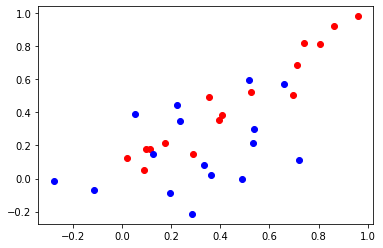

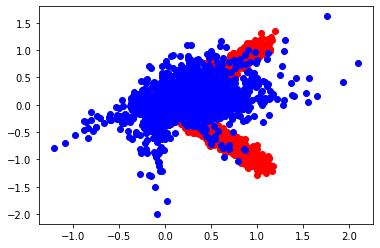

399 0.6800000071525574 0.8799999952316284


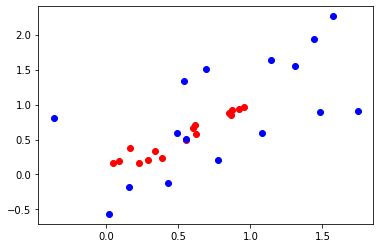

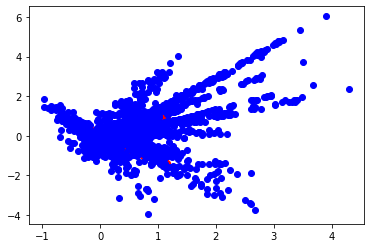

599 0.5199999809265137 0.5400000214576721


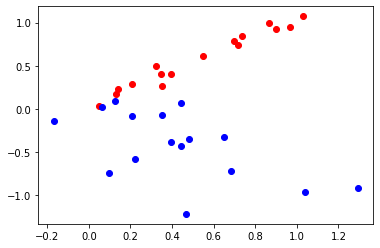

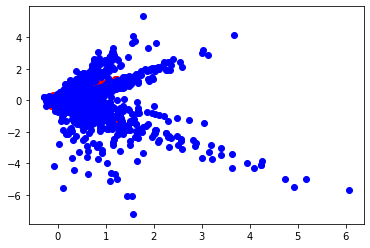

799 0.7900000214576721 0.8399999737739563


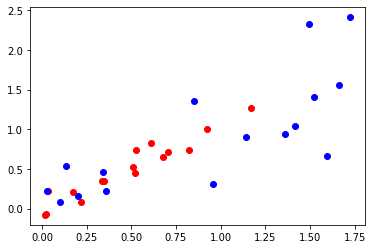

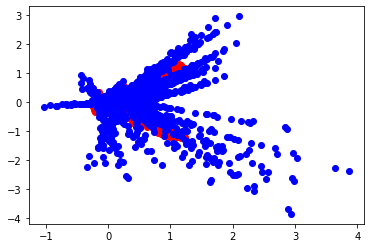

999 0.5699999928474426 0.9100000262260437


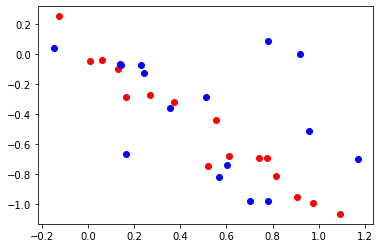

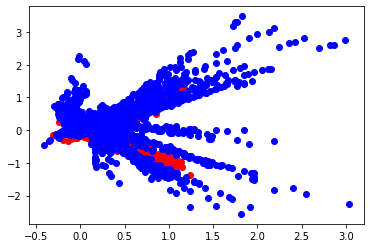

1199 0.5199999809265137 0.6800000071525574


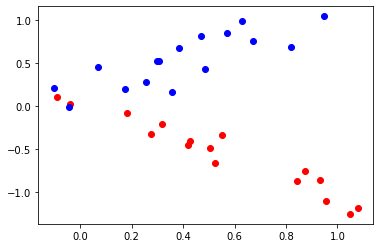

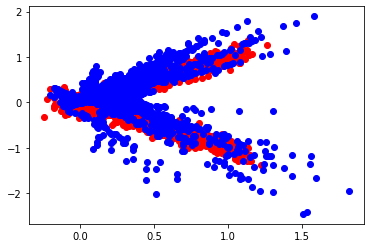

1399 0.8799999952316284 0.3799999952316284


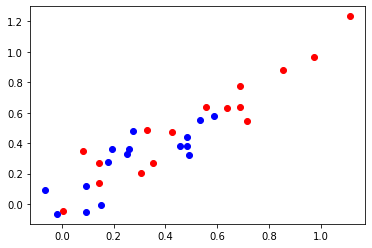

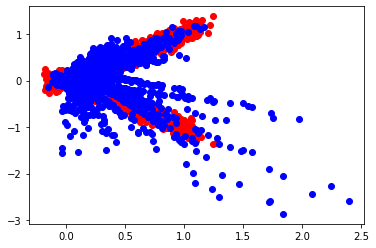

1599 0.4399999976158142 0.7400000095367432


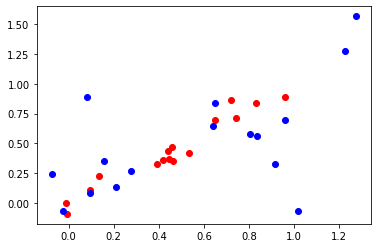

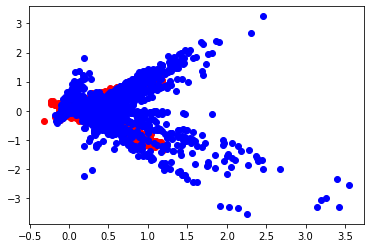

1799 0.14000000059604645 0.46000000834465027


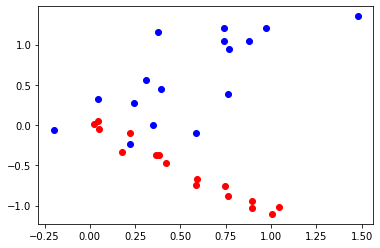

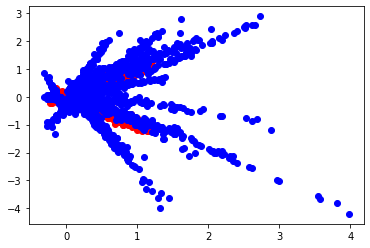

1999 0.6899999976158142 0.7599999904632568


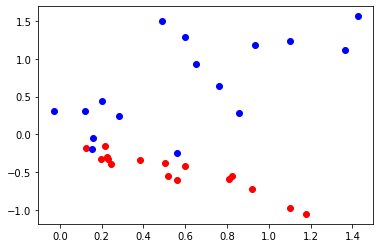

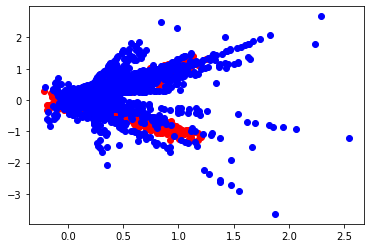

2199 0.6700000166893005 0.23000000417232513


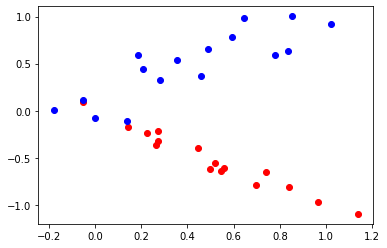

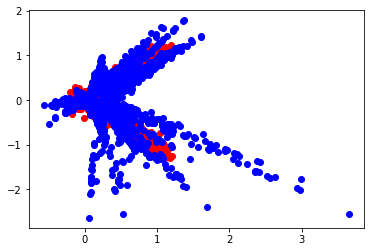

2399 0.4099999964237213 0.3799999952316284


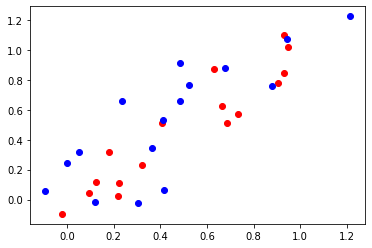

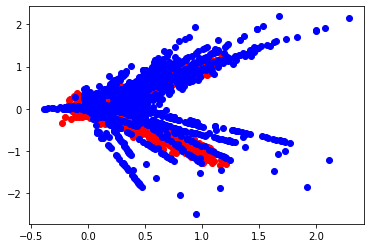

2599 0.6499999761581421 0.2800000011920929


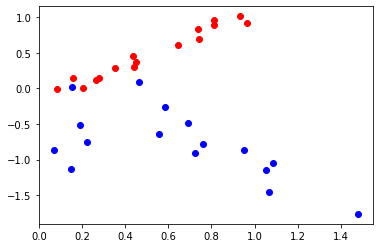

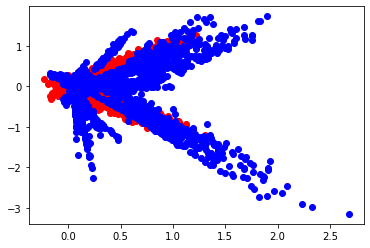

2799 0.5699999928474426 0.2800000011920929


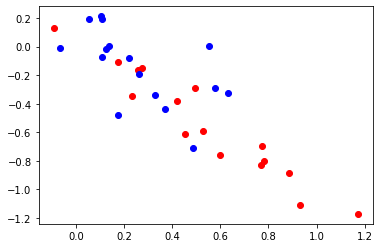

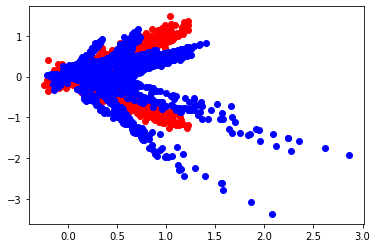

2999 0.699999988079071 0.4000000059604645


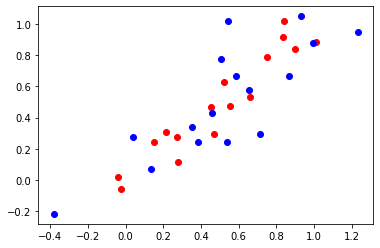

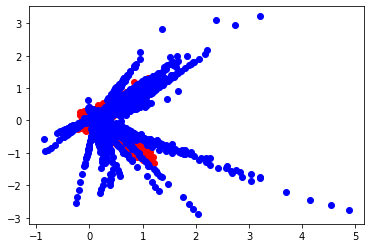

3199 0.6000000238418579 0.4099999964237213


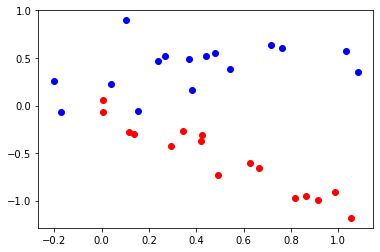

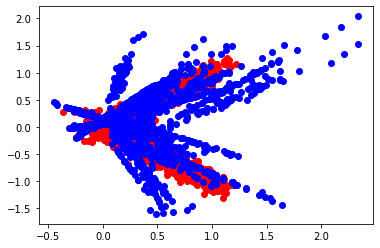

3399 0.1899999976158142 0.5400000214576721


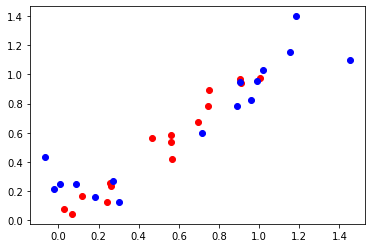

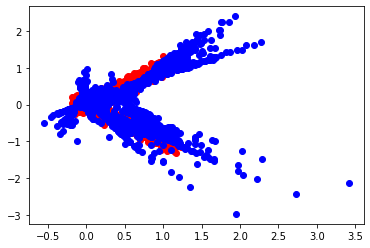

3599 0.33000001311302185 0.7400000095367432


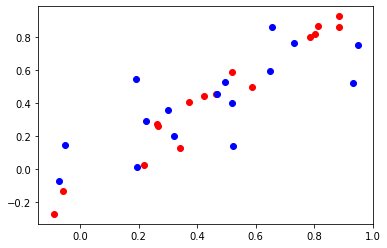

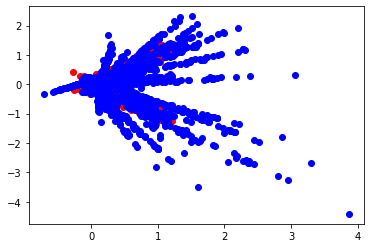

3799 0.17000000178813934 0.800000011920929


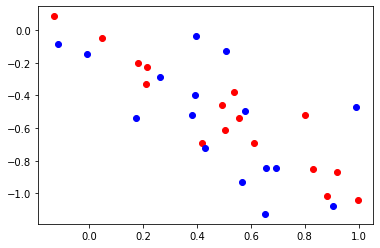

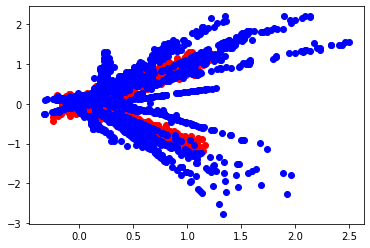

3999 0.5899999737739563 0.46000000834465027


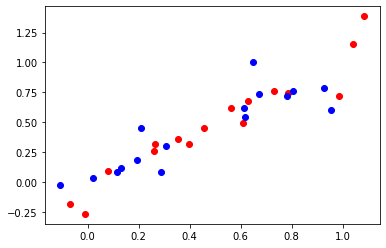

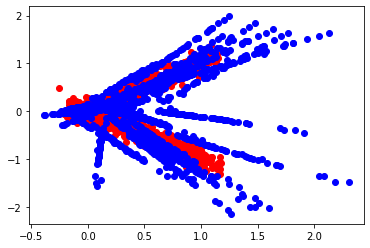

4199 0.7200000286102295 0.6100000143051147


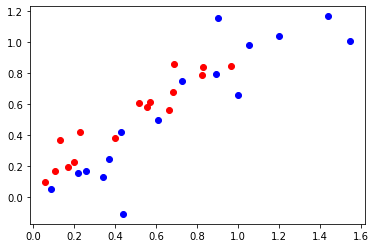

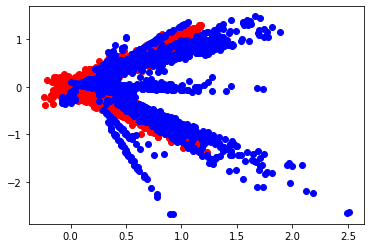

4399 0.7400000095367432 0.27000001072883606


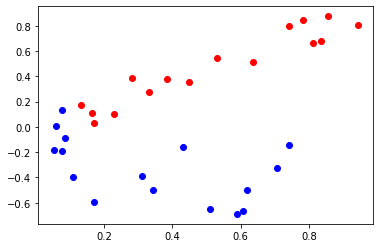

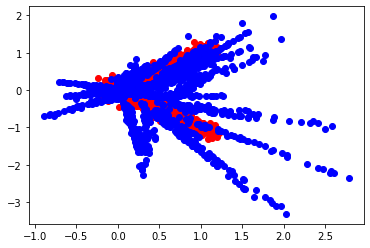

4599 0.5099999904632568 0.6000000238418579


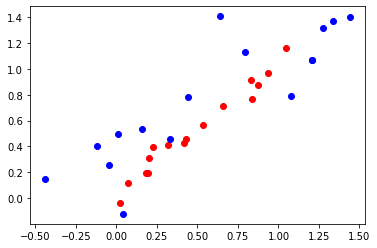

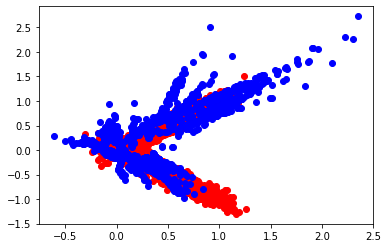

4799 0.2800000011920929 0.9200000166893005


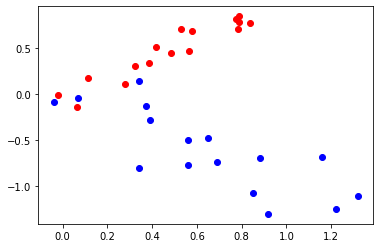

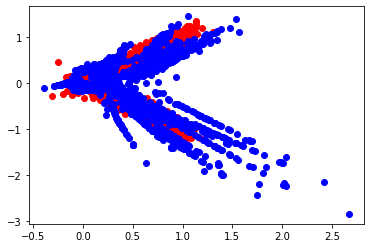

4999 0.17000000178813934 1.0


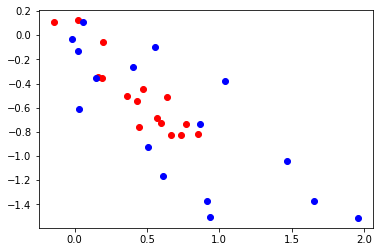

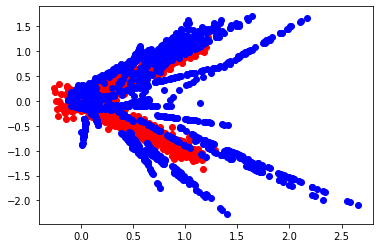

5199 0.15000000596046448 1.0


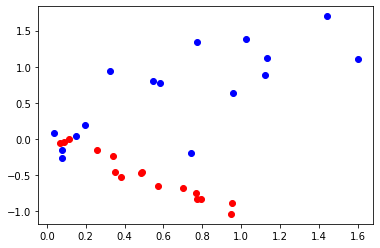

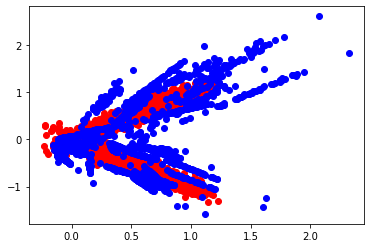

5399 0.2800000011920929 1.0


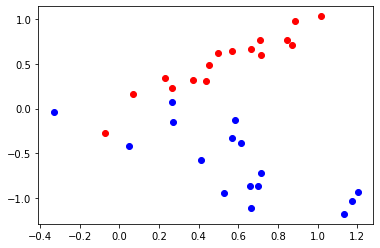

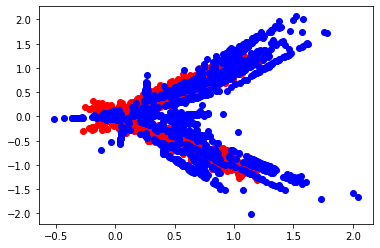

5599 0.8199999928474426 0.6000000238418579


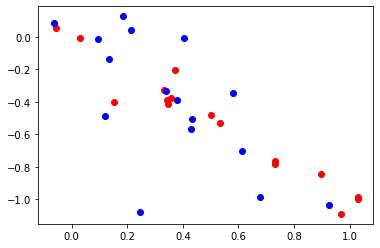

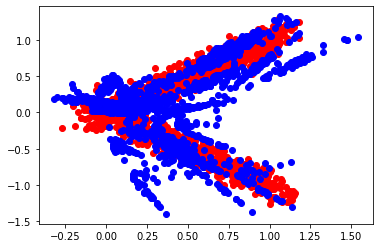

5799 0.550000011920929 0.11999999731779099


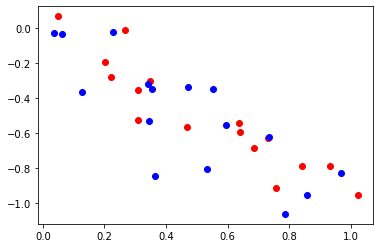

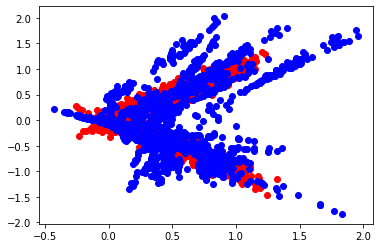

5999 0.5600000023841858 0.15000000596046448


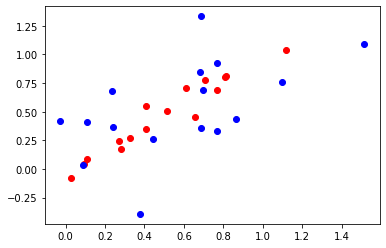

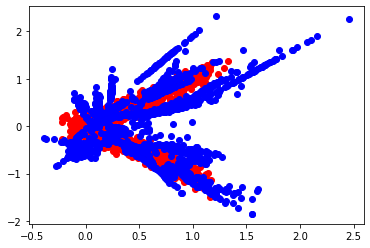

6199 0.11999999731779099 0.5799999833106995


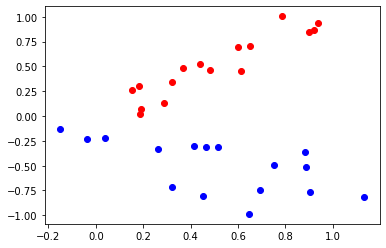

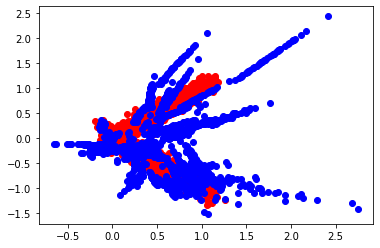

6399 0.6700000166893005 0.9200000166893005


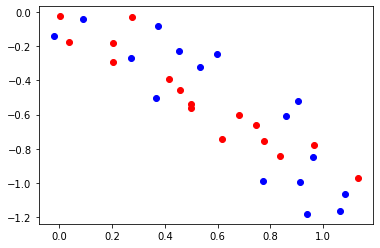

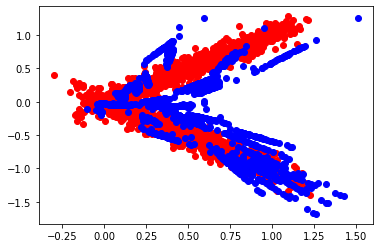

6599 0.4699999988079071 0.8999999761581421


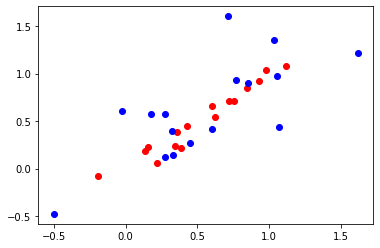

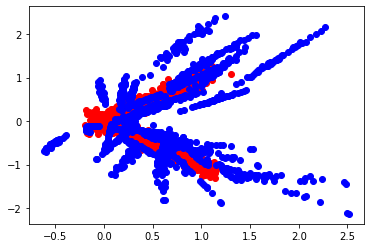

6799 0.6499999761581421 0.6200000047683716


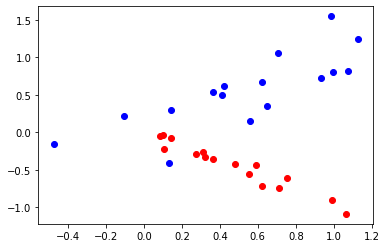

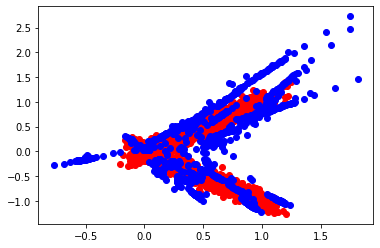

6999 0.47999998927116394 0.33000001311302185


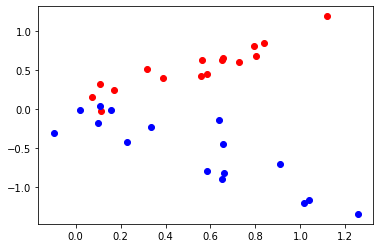

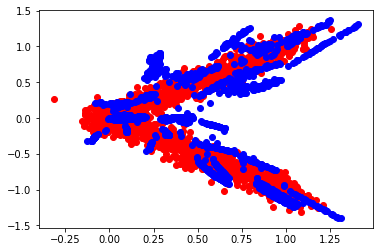

7199 0.5099999904632568 0.800000011920929


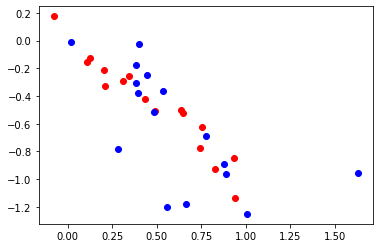

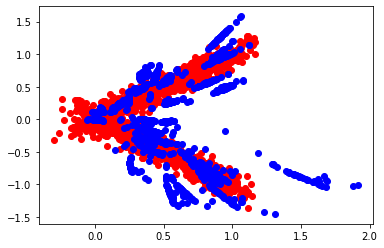

7399 0.5600000023841858 0.6800000071525574


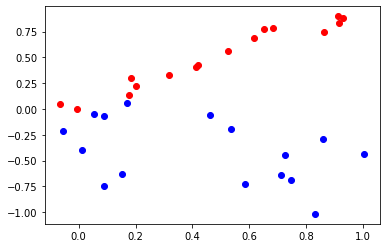

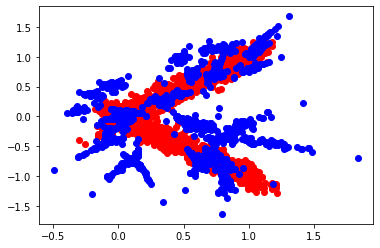

7599 0.38999998569488525 0.550000011920929


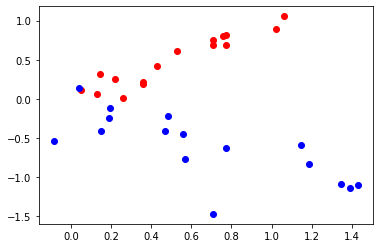

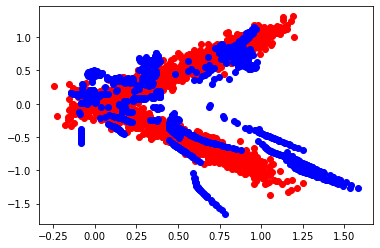

7799 0.25999999046325684 0.5299999713897705


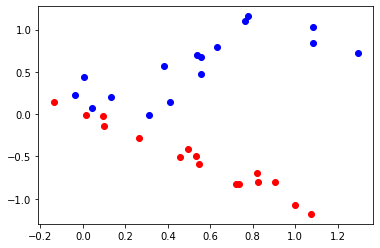

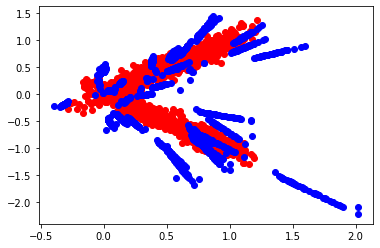

7999 0.38999998569488525 0.5


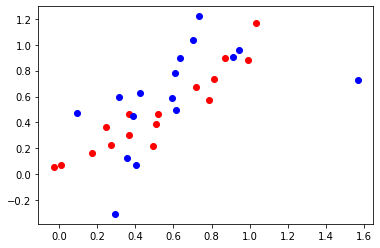

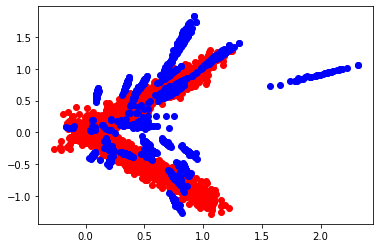

8199 0.9100000262260437 0.0


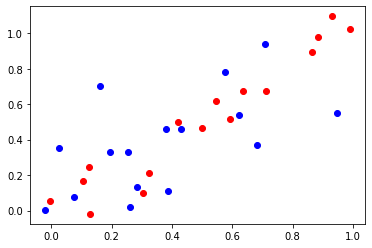

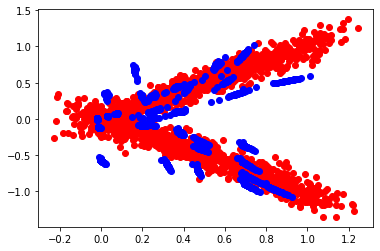

8399 0.6000000238418579 0.5099999904632568


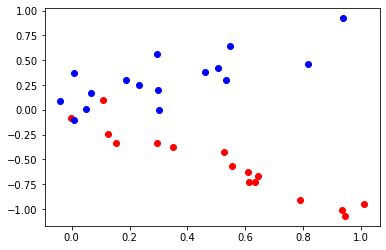

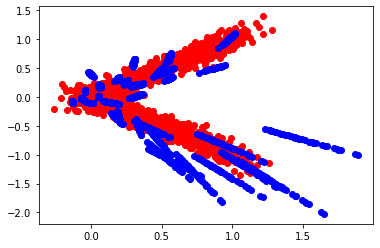

8599 0.7599999904632568 0.5400000214576721


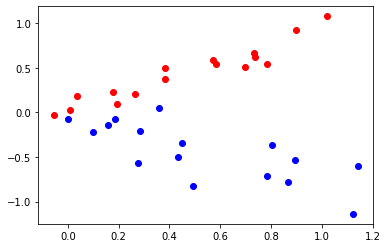

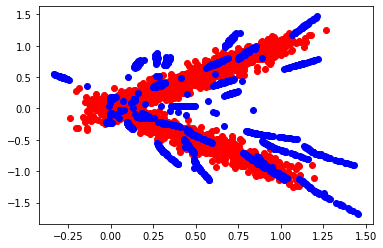

8799 0.4000000059604645 0.5299999713897705


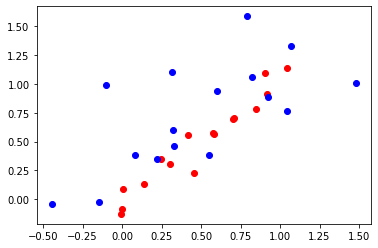

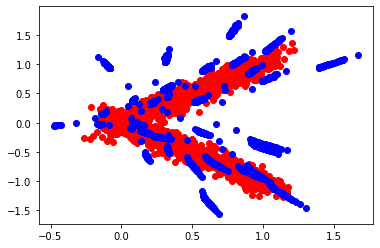

8999 0.5099999904632568 0.46000000834465027


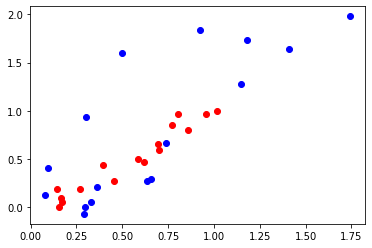

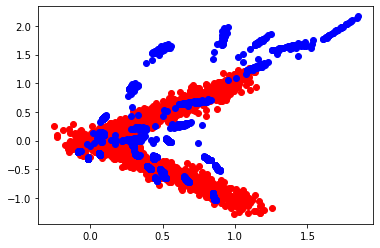

9199 0.33000001311302185 0.9900000095367432


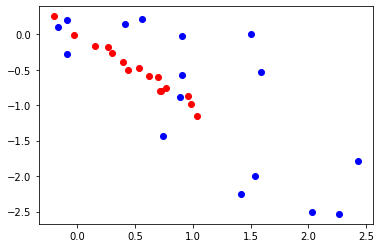

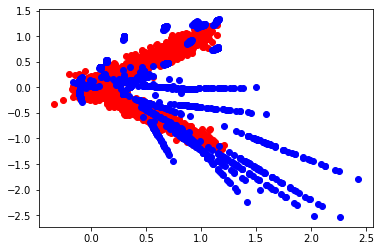

9399 0.5299999713897705 0.019999999552965164


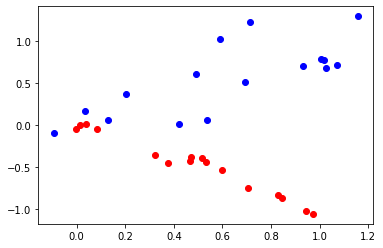

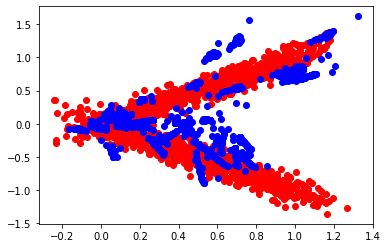

9599 0.4300000071525574 0.5


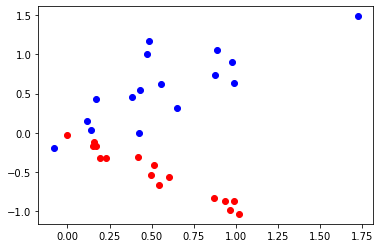

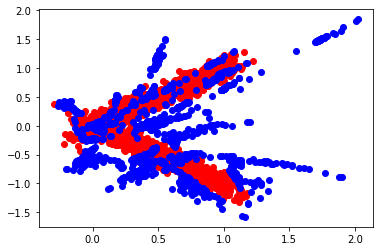

9799 0.5699999928474426 0.5400000214576721


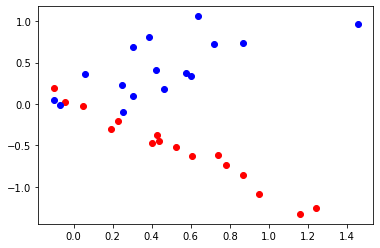

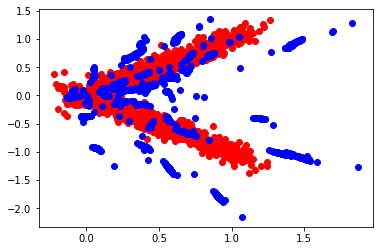

9999 0.7900000214576721 0.5099999904632568


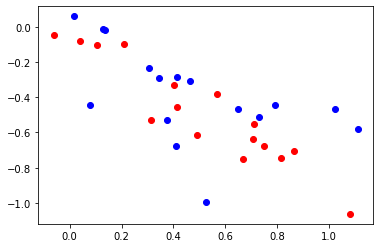

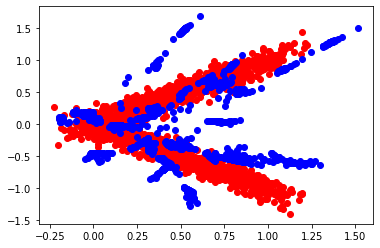

In [ ]:
# size of the latent space
latent_dim = 256
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)